In [1]:
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet201
from keras.applications.xception import Xception
from keras.optimizers import Adam
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import sys
import cv2

train_path='training_set_aligned/'
test_path='testing_set_aligned/'
valid_path='valid_set_aligned/'

img_height, img_width, img_channel = 160, 160, 3
batch_size = 32
aug_ratio = 1
epochs = 500

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# -*- coding: utf-8 -*-
import keras.applications as app


def get_model(name='vgg16',include_top=True,input_shape=None):
    if name == 'vgg16':
        model = app.vgg16.VGG16(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.vgg16.preprocess_input
    if name == 'vgg19':
        model = app.vgg19.VGG19(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.vgg19.preprocess_input
    if name == 'resnet50':
        model = app.resnet50.ResNet50(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.resnet50.preprocess_input
    if name == 'inception_v3':
        model = app.inception_v3.InceptionV3(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.inception_v3.preprocess_input
    if name == 'xception':
        model = app.xception.Xception(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.xception.preprocess_input
    if name == 'mobilenet':
        model = app.mobilenet.MobileNet(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.mobilenet.preprocess_input
    if name == 'densenet':
        model = app.densenet.DenseNet121(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.densenet.preprocess_input
    if name == 'inceptionresnet':
        model = app.inception_resnet_v2.InceptionResNetV2(weights='imagenet')
        preprocess_input = app.inception_resnet_v2.preprocess_input

    return model, preprocess_input

In [3]:
classmap_df  = pd.read_csv("classmap.csv")
classmap_df

,classname,classnum
0,rika,0
1,risa,1
2,yui,2
3,akane,3
4,neru,4


In [4]:
# train_datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=2,
#     horizontal_flip=True,
#     rescale=1./255,
#     fill_mode='nearest',
#     validation_split=0)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    fill_mode='constant',
    cval=100,
    validation_split=0)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0)


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes = classmap_df.classname.tolist(),
    class_mode='categorical',
    shuffle=True,
    seed=80) # set as training data

validation_generator = train_datagen.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes = classmap_df.classname.tolist(),
    class_mode='categorical',
    shuffle=False,
    seed=80)

# validation_generator = train_datagen.flow_from_directory(
#     train_path, 
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     classes = classmap_df.classname.tolist(),
#     class_mode='categorical',
#     shuffle=True,
#     seed=80,    
#     subset='validation') 

Found 413 images belonging to 5 classes.
Found 102 images belonging to 5 classes.


In [5]:
model_name = 'inceptionresnetv1'

base_model = load_model('facenet_keras.h5')
x = base_model.output
#x = GlobalAveragePooling2D(data_format='channels_last')(x)
#x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#model.summary()

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
model_path = './{}.h5'.format(model_name)

optimizer = Adam(lr=10e-6)
#optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
#optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])


steps_per_epoch = int(aug_ratio * train_generator.samples / train_generator.batch_size)
validation_steps = int(aug_ratio * validation_generator.samples / validation_generator.batch_size)
model_history = model.fit_generator(train_generator,
                                    epochs = epochs,
                                    validation_data = validation_generator,
                                    callbacks = [checkpoint, learning_rate_reduction],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/500
12/12 [==============================] - 21s 2s/step - loss: 1.8095 - acc: 0.1891 - val_loss: 1.6238 - val_acc: 0.2941

Epoch 00001: val_loss improved from inf to 1.62381, saving model to ./inceptionresnetv1.h5
Epoch 2/500
12/12 [==============================] - 3s 290ms/step - loss: 1.7760 - acc: 0.1993 - val_loss: 1.6329 - val_acc: 0.2451

Epoch 00002: val_loss did not improve from 1.62381
Epoch 3/500
12/12 [==============================] - 4s 304ms/step - loss: 1.7269 - acc: 0.2128 - val_loss: 1.5806 - val_acc: 0.3431

Epoch 00003: val_loss improved from 1.62381 to 1.58061, saving model to ./inceptionresnetv1.h5
Epoch 4/500
12/12 [==============================] - 3s 265ms/step - loss: 1.7368 - acc: 0.2261 - val_loss: 1.5725 - val_acc: 0.3824

Epoch 00004: val_loss improved from 1.58061 to 1.57247, saving model to ./inceptionresnetv1.h5
Epoch 5/500
12/12 [==============================] - 3s 274ms/step - loss: 1.7093 - acc: 0.2405 - val_loss: 1.5763 - val_acc: 0.3039



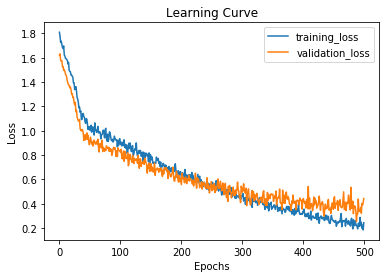

In [7]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

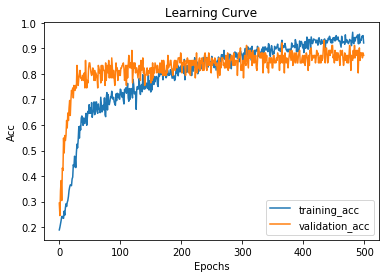

In [8]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [9]:
STEP_SIZE_VALID=validation_generator.samples//validation_generator.batch_size
model.evaluate_generator(generator=validation_generator,steps=STEP_SIZE_VALID)

[0.41051386793454486, 0.8645833333333334]

(299, 299, 3)
(1, 299, 299, 3)


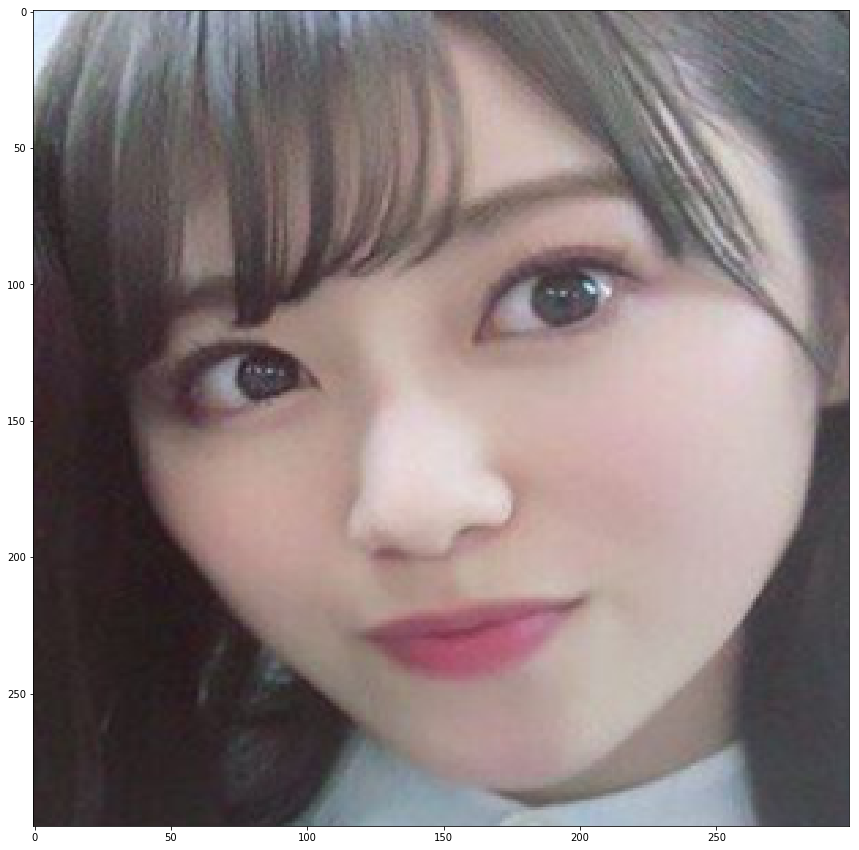

In [10]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

imgForTest = "training_set_aligned/akane/023.png"
img = cv2.imread(imgForTest)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)
img = img.reshape((1,) + img.shape)
print(img.shape)

i = 0
for batch in train_datagen.flow(img, batch_size=10,save_to_dir="augmentation/", save_prefix="akane", save_format="png"):
    plt.subplot(5,4,1 + i)
    plt.axis("off")
    augImage = batch[0]
    augImage = augImage.astype("float32")
    #augImage /= 255
    plt.imshow(augImage)
    i += 1
    if i > 19:
        break

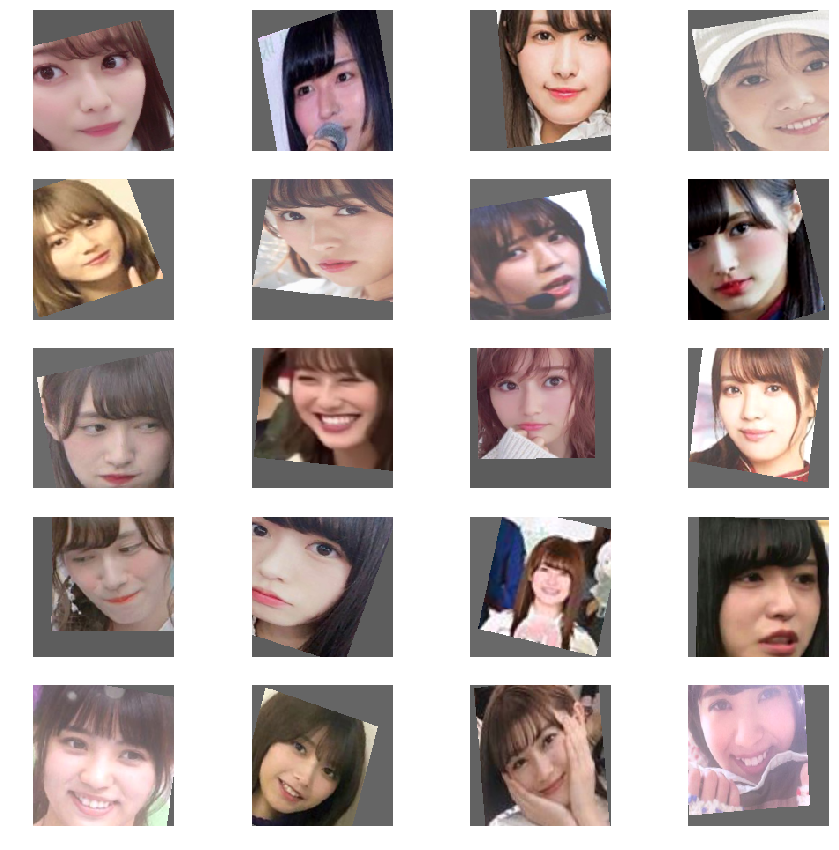

In [11]:
import utils

i = 0
for data_batch, labels_batch in train_generator:
    for batch in data_batch:
        plt.subplot(5,4,1 + i)
        plt.axis("off")
        augImage = batch
        augImage = augImage.astype("float32")
        #augImage /= 255
        plt.imshow(augImage)
        i += 1
        if i > 19:
            break
    if i > 19:
        break

import numpy as np

#from tensorflow.keras.models import Model
#from keras.models import Model
from keras import backend as K

import utils
from model import get_model
from vis import conv_output, conv_filter, output_heatmap

layer_name = 'conv2d_1 '
last_conv_layer = 'conv2d_4'

img_path = 'training_set_aligned/akane/023.png'
model_1, preprocess_input = get_model('xception')
img, pimg = utils.read_img(img_path, preprocess_input, (299, 299))
#model.summary()

In [12]:
import numpy as np

from keras import backend as K

import utils
from model import get_model
from vis import conv_output, conv_filter, output_heatmap

layer_name = 'Conv2d_4b_3x3'
last_conv_layer = 'Block8_6_Branch_1_Conv2d_0a_1x1'

img_path = 'training_set_aligned/akane/024.png'
model_1, preprocess_input = get_model('inceptionresnet')
img, pimg = utils.read_img(img_path, preprocess_input, (160, 160))
#model.summary()

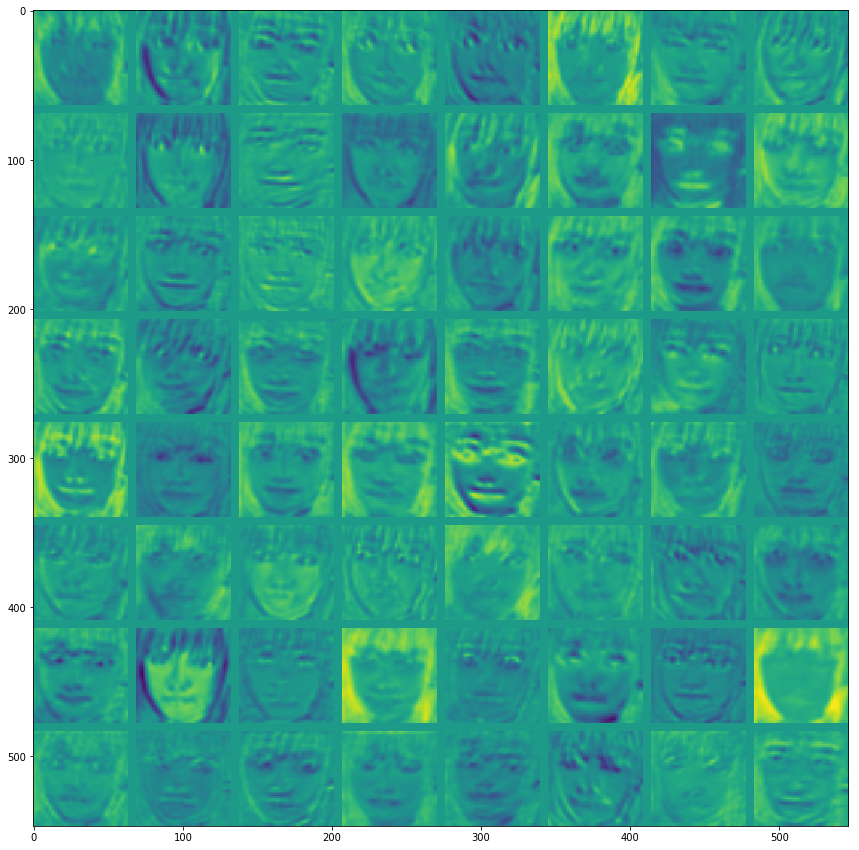

In [13]:
layer_name = 'Conv2d_4a_3x3'
cout = conv_output(model, layer_name, pimg)
utils.vis_conv(cout, 8, layer_name, 'conv')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


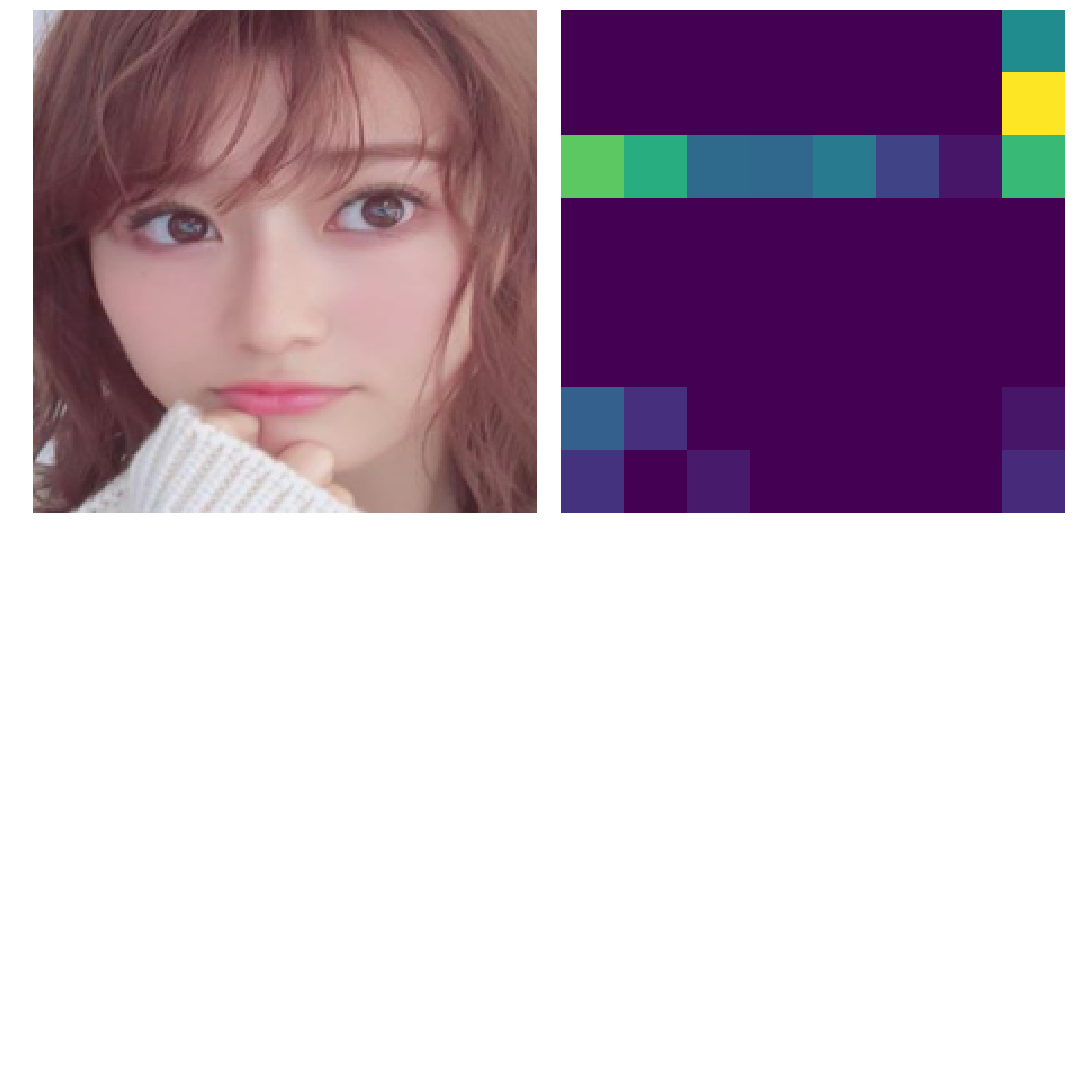

In [14]:
img_path = 'training_set_aligned/akane/033.png'
img, pimg = utils.read_img(img_path, preprocess_input, (160, 160))

last_conv_layer = 'Mixed_7a_Branch_2_Conv2d_0b_3x3'
heatmap = output_heatmap(model, last_conv_layer, pimg)
utils.vis_heatmap(img, heatmap)

for layer in model.layers:
    print(layer.name,layer.trainable)

import dlib

import mtcnn

!git commit -a -m "inceptionresnet 1000 epoch"
!git push -u origin master